# Synthetic data test
This notebook was used to perform tests for the synthetic data generation.  
Steps:
  1. Add neurons as gaussians (foreground)
  2. Deform image (warping, different shapes, translation, etc.)
     * Sample from warped neurons to get pixelated aspect
  3. Add background noise

In [1]:
%matplotlib inline

import os, time, pickle
import warnings
import math
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, draw
from scipy import stats, special
from scipy.stats import multivariate_normal, entropy, norm
from scipy.special import gamma, digamma, polygamma
from imgaug import augmenters as iaa

from utils_common.image import imread_to_float, overlay_mask, to_npint
from utils_common.processing import flood_fill

%load_ext autoreload
%autoreload 2

In [2]:
shape = (192, 256)

# True data statistics
  1. Compute array of pixels intensity based on background/foreground segmentation
  2. Compute intensity statistics about ROIs

In [3]:
# Some pre-computed statistics
print("2'347'442'181 background pixels")
print("   19'226'619 foreground pixels")
print("ROI (averaged through 96296 ROIs):")
print("  - max = 0.7393784198069026")
print("  - ave = 0.23897667648932133")
print("  - med = 0.21552928307652713")
print("  - q75 = 0.3407044374616175")

with open("stats_181121.pkl", "rb") as f:
    pixel_bkg, pixel_fg, roi_max, roi_ave, roi_med, roi_q75 = pickle.load(f)
        
    # Following are probability for bkg/fg pixels, simply hist/hist.sum()
    p_bkg = pixel_bkg / pixel_bkg.sum()
    p_fg = pixel_fg / pixel_fg.sum()
    
    # Following are for the ROI region only
    p_roi_max = roi_max / roi_max.sum()
    p_roi_ave = roi_ave / roi_ave.sum()
    p_roi_med = roi_med / roi_med.sum()
    p_roi_q75 = roi_q75 / roi_q75.sum()

2'347'442'181 background pixels
   19'226'619 foreground pixels
ROI (averaged through 96296 ROIs):
  - max = 0.7393784198069026
  - ave = 0.23897667648932133
  - med = 0.21552928307652713
  - q75 = 0.3407044374616175


Display them (restructure them from 256 bins to 20 for better visualization).

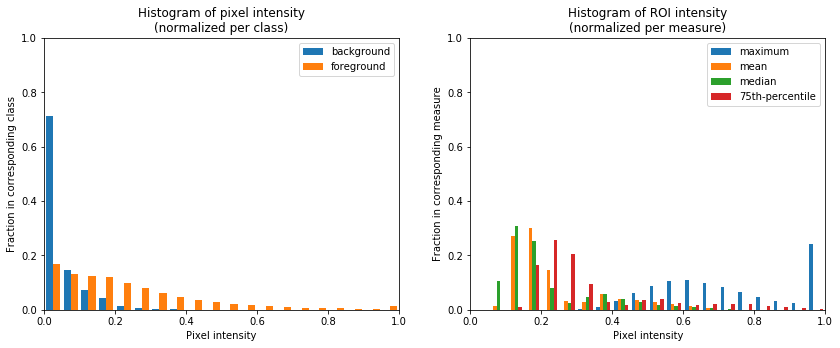

In [4]:
# Restructure the bins for plotting purposes
increment = 0.05
new_bins = np.arange(0, 1 + increment, increment)
increment_to_int = int(np.rint(255 / (new_bins.size - 1)))
new_pixel_bkg = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_pixel_fg = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_max = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_ave = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_med = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_q75 = np.zeros(new_bins.size - 1, dtype=np.uint32)
for i in range(new_bins.size - 1):
    new_pixel_bkg[i] = pixel_bkg[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_pixel_fg[i] = pixel_fg[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_max[i] = roi_max[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_ave[i] = roi_ave[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_med[i] = roi_med[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_q75[i] = roi_q75[i * increment_to_int: (i + 1) * increment_to_int].sum()

# Bars' parameters
ratio_bar = 0.80 # ratio of bar_width/interval_width
width = increment * ratio_bar / 2
offset_left = (increment - width) / 2
offset_right = (increment + width) / 2

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.bar(new_bins[:-1] + offset_left, new_pixel_bkg / new_pixel_bkg.sum(), width=width)
plt.bar(new_bins[:-1] + offset_right, new_pixel_fg / new_pixel_fg.sum(), width=width)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of pixel intensity\n(normalized per class)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding class")
plt.legend(["background", "foreground"])

plt.subplot(122)
plt.bar(new_bins[:-1] + offset_left - width/4, new_roi_max / new_roi_max.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_left + width/4, new_roi_ave / new_roi_ave.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_right - width/4, new_roi_med / new_roi_med.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_right + width/4, new_roi_q75 / new_roi_q75.sum(), width=width/2)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of ROI intensity\n(normalized per measure)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding measure")
plt.legend(["maximum", "mean", "median", "75th-percentile"])
plt.show()

# 1. Neurons generation

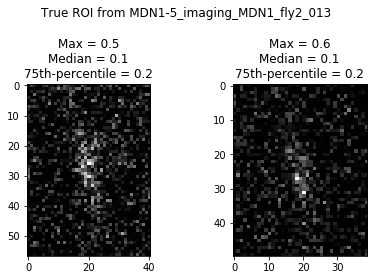

In [5]:
# Load a random true example
rand_exp = np.random.choice(os.listdir("/data/talabot/dataset/train/"))
neuron_ex = imread_to_float(os.path.join("./data/talabot/dataset/train/", rand_exp, "RGB.tif"))[..., 0]
gt_ex = imread_to_float(os.path.join("/data/talabot/dataset/train/", rand_exp, "seg_ROI.tif"))
rand_n = np.random.randint(neuron_ex.shape[0])

labels = measure.label(gt_ex[rand_n])
plt.figure()
plt.suptitle("True ROI from %s" % rand_exp)
n = 0
for region in measure.regionprops(labels):
    n += 1
    min_r, min_c, max_r, max_c = region.bbox
    min_r = max(0, min_r - 15)
    max_r = min(gt_ex[rand_n].shape[0], max_r + 15)
    min_c = max(0, min_c - 15)
    max_c = min(gt_ex[rand_n].shape[1], max_c + 15)
    plt.subplot(1,labels.max(),n)
    plt.imshow(neuron_ex[rand_n, min_r:max_r, min_c:max_c], cmap='gray')
    plt.title("Max = %.1f\nMedian = %.1f\n75th-percentile = %.1f" % \
              (np.max(neuron_ex[rand_n][labels == region.label]),
               np.median(neuron_ex[rand_n][labels == region.label]),
               np.percentile(neuron_ex[rand_n][labels == region.label], 75)))
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

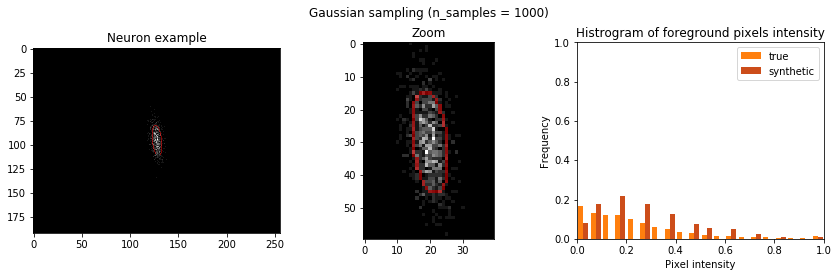

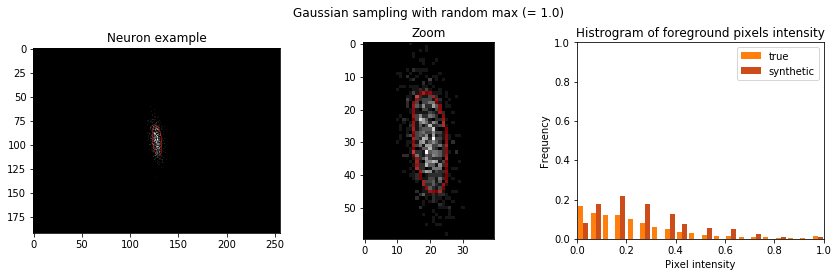

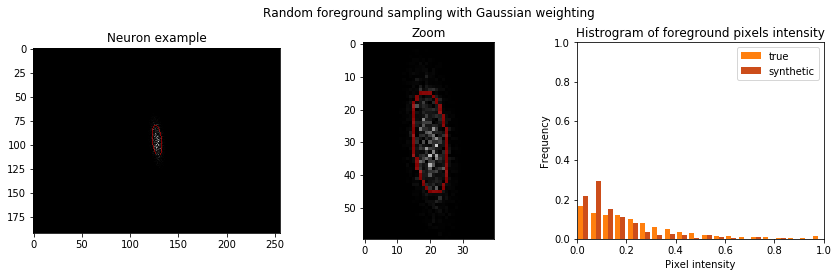

In [6]:
mean = np.array([shape[1]/2, shape[0]/2])
cov = np.array([[10, 10],
                [10, 100]])
n_samples = 1000
ellipse_size = 1.5 # factor for the ground truth ellipse (normalized by std)

bkg = np.zeros(shape, dtype=np.float32)

# Bounding ellipse
val, vec = np.linalg.eig(cov)
rotation = math.atan2(vec[0, np.argmax(val)], vec[1, np.argmax(val)])
rr, cc = draw.ellipse(mean[1], mean[0], 
                      ellipse_size * np.sqrt(cov[1][1]), ellipse_size * np.sqrt(cov[0][0]), 
                      shape=shape, rotation=rotation)
neuron_seg = np.zeros(shape, dtype=bool)
neuron_seg[rr, cc] = True
tmp_contour = np.concatenate(measure.find_contours(neuron_seg, 0)).astype(np.int)
contour = np.zeros(shape, dtype=bool)
contour[tmp_contour[:,0], tmp_contour[:,1]] = True

# Define some plotting functions
def plot_neuron(neuron, contour, title):
    img_display = overlay_mask(neuron, contour, opacity=0.5, mask_color=[1,0,0])
    coords = np.nonzero(contour)
    min_r = int(max(0, coords[0].min() - 15))
    max_r = int(min(shape[0], coords[0].max() + 15))
    min_c = int(max(0, coords[1].min() - 15))
    max_c = int(min(shape[1], coords[1].max() + 15))
    neuron_hist = plt.hist(neuron[neuron_seg].ravel(), align="mid", bins=new_bins, 
                          weights=np.ones(neuron[neuron_seg].size) / neuron[neuron_seg].size)[0]
    plt.close()
    
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    plt.subplot(131)
    plt.imshow(img_display, cmap='gray')
    plt.title("Neuron example")
    plt.subplot(132)
    plt.imshow(img_display[min_r:max_r, min_c:max_c], cmap='gray')
    plt.title("Zoom")
    plt.subplot(133)
    plt.bar(new_bins[:-1] + offset_left, new_pixel_fg / new_pixel_fg.sum(), width=width, color="C1")
    plt.bar(new_bins[:-1] + offset_right, neuron_hist, width=width, color=[0.8, 0.3, 0.1])
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.title("Histrogram of foreground pixels intensity")
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    plt.legend(["true", "synthetic"])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Gaussian sampling
x, y = np.random.multivariate_normal(mean, cov, n_samples).T
hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])
plt.close()
neuron = hist[0].T / hist[0].max()
neuron1 = neuron

plot_neuron(neuron1, contour, "Gaussian sampling (n_samples = %d)" % (n_samples))

# Gaussian sampling, maximum randomly sampled
max_neuron = np.random.choice(256, p=p_roi_max) / 255
neuron2 = (bkg + neuron) * max_neuron

plot_neuron(neuron2, contour, "Gaussian sampling with random max (= %.1f)" % max_neuron)

# Random foreground sampling with gaussian weights
rr, cc = draw.ellipse(mean[1], mean[0], 3*np.sqrt(cov[1][1]), 3*np.sqrt(cov[0][0]), shape=shape, rotation=rotation)
fg_pixels = np.random.choice(256, size=rr.size, p=p_fg) / 255
neuron3 = np.zeros_like(neuron)
neuron3[rr, cc] = fg_pixels
gauss_weight = np.zeros_like(neuron)
for i in range(rr.size):
    gauss_weight[rr[i], cc[i]] = multivariate_normal.pdf([cc[i], rr[i]], mean=mean, cov=cov)
neuron3 *= gauss_weight / gauss_weight.max()

plot_neuron(neuron3, contour, "Random foreground sampling with Gaussian weighting")

Create multiple neurons at once (as gaussian weights).

Frequency of intensity 1.0: 0.2276730082246407

Mean and std: 0.662550211285504 0.13925117610178625
Random sampling: 0.5239741673014526


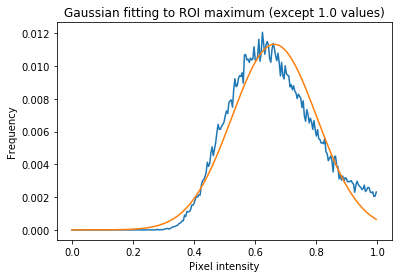

In [7]:
# Maximum ROI fitting with Gaussian
print("Frequency of intensity 1.0:", p_roi_max[-1])

tmp_p_roi_max = p_roi_max.copy()[:-1]
tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
print("\nMean and std:", loc, scale)
print("Random sampling:", np.clip(np.random.normal(loc=loc, scale=scale), 0, 1))
    
plt.plot(np.arange(255) / 255, tmp_p_roi_max)
gauss = norm.pdf(np.arange(255) / 255, loc=loc, scale=scale)
plt.plot(np.arange(255) / 255, gauss / gauss.sum())
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.title("Gaussian fitting to ROI maximum (except 1.0 values)")
plt.show()

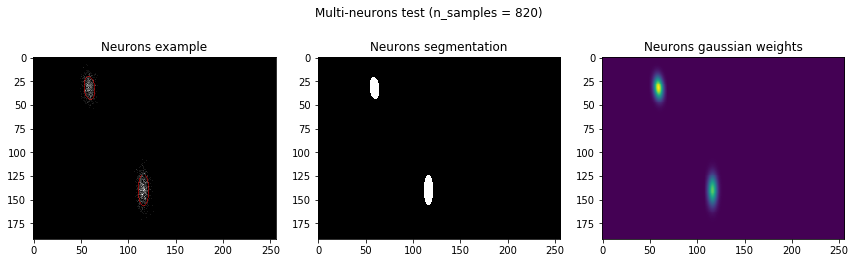

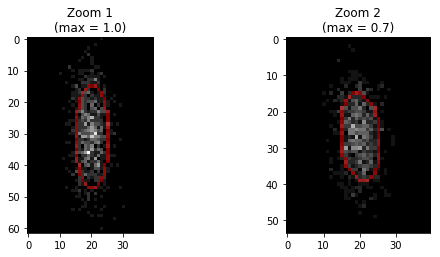

In [8]:
ellipse_size = 1.5 # factor for the ground truth ellipse (normalized by std)
n_neurons = 2
n_samples = int(np.random.normal(loc=1000, scale=200) + 0.5)

bkg = np.zeros(shape, dtype=np.float32)

means = np.zeros((n_neurons, 2))
covs = np.zeros((n_neurons, 2, 2))
neurons_segs = np.zeros((n_neurons,) + shape, dtype=np.bool)
contours = np.zeros((n_neurons,) + shape, dtype=np.bool)
neurons = np.zeros(shape)
max_neurons = []
for i in range(n_neurons):
    # Create neuron infinitly until in image and no overlap with another
    # TODO: change this to something that cannot loop to infinity
    while True:
        # Mean and covariance matrix of gaussian (manually tuned)
        # Note that x and y axes are col and row (so, inversed!)
        means[i] = np.array([np.random.randint(shape[1]), np.random.randint(shape[0])])
        scale_x = shape[1] / 50
        scale_y = shape[0] / 50
        cross_corr = np.random.randint(-2, 2) * min(scale_x, scale_y)
        covs[i] = np.array([
            [np.random.randint(1, 3) * scale_x, cross_corr],
            [cross_corr, np.random.randint(10, 30) * scale_y]
        ])

        # Bounding ellipses
        val, vec = np.linalg.eig(covs[i])
        rotation = math.atan2(vec[0, np.argmax(val)], vec[1, np.argmax(val)])
        rr, cc = draw.ellipse(means[i,1], means[i,0], 
                              ellipse_size * np.sqrt(covs[i,1,1]), ellipse_size * np.sqrt(covs[i,0,0]),
                              rotation=rotation)
        # Check if outside the image
        if (rr < 0).any() or (rr >= shape[0]).any() or (cc < 0).any() or (cc >= shape[1]).any():
            continue
        # Check if overlapping with any existing neuron
        elif (neurons_segs[:, rr, cc] == True).any():
            continue
        else:
            break
    neurons_segs[i, rr, cc] = True
    tmp_contour = np.concatenate(measure.find_contours(neurons_segs[i], 0)).astype(np.int)
    contours[i, tmp_contour[:,0], tmp_contour[:,1]] = True
    
    # Gaussian sampling
    x, y = np.random.multivariate_normal(means[i], covs[i], n_samples).T
    hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])
    plt.close()
    # Random maximum sampling 
    # First, check if 1.0, then gaussian sampling
    if np.random.rand() < p_roi_max[-1]:
        max_neurons.append(1.0)
    else:
        tmp_p_roi_max = p_roi_max.copy()[:-1]
        tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
        loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
        scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
        max_neurons.append(np.clip(np.random.normal(loc=loc, scale=scale), 0, 1))
    
    neurons = np.maximum(neurons, hist[0].T / hist[0].max() * max_neurons[i])
# Reduce segmentations
neurons_segs = neurons_segs.sum(axis=0)

# Create gaussian weights images
rows, cols = np.arange(shape[0]), np.arange(shape[1])
grid = np.zeros(shape + (2,))
grid[:,:,0], grid[:,:,1] = np.meshgrid(cols, rows) # note the order!
neurons_gaussians = np.zeros((n_neurons,) + shape)
for i in range(n_neurons):
    neurons_gaussians[i,:,:] = multivariate_normal.pdf(grid, means[i], covs[i])
    neurons_gaussians[i,:,:] /= neurons_gaussians[i,:,:].sum()

# Plot results
img_display = overlay_mask(neurons, contours.sum(0), opacity=0.5, mask_color=[1,0,0])

plt.figure(figsize=(12, 4))
plt.suptitle("Multi-neurons test (n_samples = %d)" % (n_samples))
plt.subplot(131)
plt.imshow(img_display)
plt.title("Neurons example")
plt.subplot(132)
plt.imshow(neurons_segs, cmap='gray')
plt.title("Neurons segmentation")
plt.subplot(133)
plt.imshow(neurons_gaussians.max(0))
plt.title("Neurons gaussian weights")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.figure(figsize=(8,4))
for i in range(n_neurons):
    coords = np.nonzero(contours[i])
    min_r = int(max(0, coords[0].min() - 15))
    max_r = int(min(shape[0], coords[0].max() + 15))
    min_c = int(max(0, coords[1].min() - 15))
    max_c = int(min(shape[1], coords[1].max() + 15))
    plt.subplot(1, n_neurons, i + 1)
    plt.imshow(img_display[min_r:max_r, min_c:max_c])
    plt.title("Zoom %d\n(max = %.1f)" % (i+1, max_neurons[i]))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Deformations

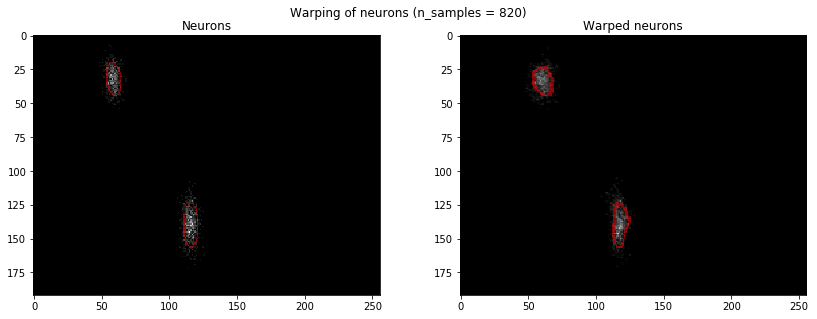

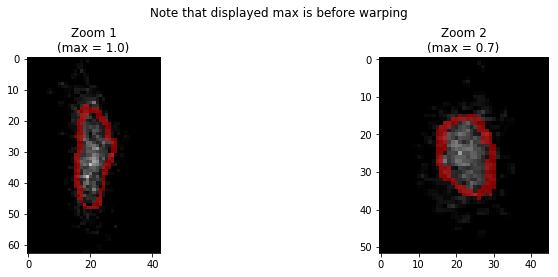

In [9]:
grid_size = 8

# Define warping sequence
wrpseq = iaa.Sequential([
    iaa.PiecewiseAffine(scale=0.025, nb_rows=grid_size, nb_cols=grid_size)
])
seq_det = wrpseq.to_deterministic()

wrp_contours = np.zeros_like(contours)
for i in range(len(contours)):
    wrp_contours[i] = seq_det.augment_image(contours[i])
wrp_segs = seq_det.augment_image(neurons_segs)
wrp_neurons = seq_det.augment_image(neurons)

# Fill the possible holes in warped segmentation
# To avoid the case where a neurons blocks the origin, add fake background boundaries
wrp_segs = flood_fill(np.pad(wrp_segs, 1, 'constant'))[1:-1, 1:-1]

img_display = overlay_mask(neurons, contours.sum(0), opacity=0.5, mask_color=[1,0,0])
wrp_img_display = overlay_mask(wrp_neurons, wrp_contours.sum(0), opacity=0.5, mask_color=[1,0,0])

plt.figure(figsize=(12,4.5))
plt.suptitle("Warping of neurons (n_samples = %d)" % n_samples)
plt.subplot(121)
plt.title("Neurons")
plt.imshow(img_display)
plt.subplot(122)
plt.title("Warped neurons")
plt.imshow(wrp_img_display)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.figure(figsize=(12,4))
plt.suptitle("Note that displayed max is before warping")
for i in range(n_neurons):
    coords = np.nonzero(wrp_contours[i])
    min_r = int(max(0, coords[0].min() - 15))
    max_r = int(min(shape[0], coords[0].max() + 15))
    min_c = int(max(0, coords[1].min() - 15))
    max_c = int(min(shape[1], coords[1].max() + 15))
    plt.subplot(1, n_neurons, i + 1)
    plt.imshow(wrp_img_display[min_r:max_r, min_c:max_c])
    plt.title("Zoom %d\n(max = %.1f)" % (i+1, max_neurons[i]))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

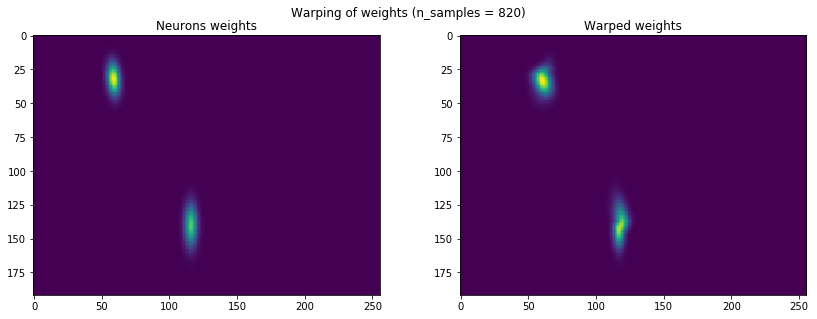

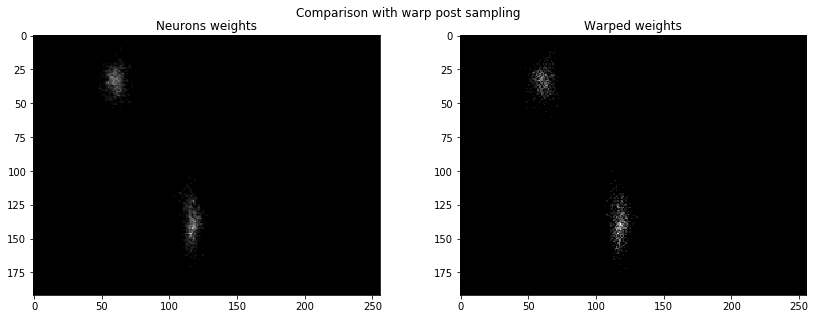

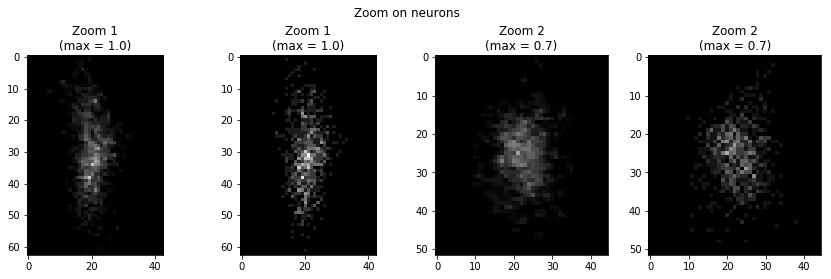

In [10]:
# Warp the gaussian weighting, and sample afterwards
wrp_gaussians = np.zeros_like(neurons_gaussians)
for i in range(n_neurons):
    wrp_gaussians[i] = seq_det.augment_image(neurons_gaussians[i])
    wrp_gaussians[i] /= wrp_gaussians[i].sum()

wrp_neurons_weight = np.zeros_like(neurons)
for i in range(n_neurons):
    x = np.random.choice(np.arange(wrp_neurons_weight.size), size=n_samples, p=wrp_gaussians[i].ravel())
    y, x = np.unravel_index(x, shape)
    hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])
    plt.close()
    
    wrp_neurons_weight = np.maximum(wrp_neurons_weight, hist[0].T / hist[0].max() * max_neurons[i])

plt.figure(figsize=(12,4.5))
plt.suptitle("Warping of weights (n_samples = %d)" % n_samples)
plt.subplot(121)
plt.title("Neurons weights")
plt.imshow(neurons_gaussians.sum(0))
plt.subplot(122)
plt.title("Warped weights")
plt.imshow(wrp_gaussians.sum(0))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.figure(figsize=(12,4.5))
plt.suptitle("Comparison with warp post sampling")
plt.subplot(121)
plt.title("Neurons weights")
plt.imshow(wrp_neurons, vmin=0, vmax=1, cmap='gray')
plt.subplot(122)
plt.title("Warped weights")
plt.imshow(wrp_neurons_weight, vmin=0, vmax=1, cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.figure(figsize=(12,4))
plt.suptitle("Zoom on neurons")
for i in range(n_neurons):
    coords = np.nonzero(wrp_contours[i])
    min_r = int(max(0, coords[0].min() - 15))
    max_r = int(min(shape[0], coords[0].max() + 15))
    min_c = int(max(0, coords[1].min() - 15))
    max_c = int(min(shape[1], coords[1].max() + 15))
    plt.subplot(1, 2*n_neurons, i*2 + 1)
    plt.imshow(wrp_neurons[min_r:max_r, min_c:max_c], vmin=0, vmax=1, cmap='gray')
    plt.title("Zoom %d\n(max = %.1f)" % (i+1, max_neurons[i]))
    plt.subplot(1, 2*n_neurons, i*2 + 2)
    plt.imshow(wrp_neurons_weight[min_r:max_r, min_c:max_c], vmin=0, vmax=1, cmap='gray')
    plt.title("Zoom %d\n(max = %.1f)" % (i+1, max_neurons[i]))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Noise

Tests different distributions to fit noise. 
*Results:* Exponential distribution to sample background noise.

**Note:** We won't use Gamma and Beta as they are not defined in 0. Hence, they need an offset, but are too dependent on this offset.

After 5 iterations:
best_LL = 2.1063011946155648
k = 0.7917790387034535
theta = 0.05766092226814912


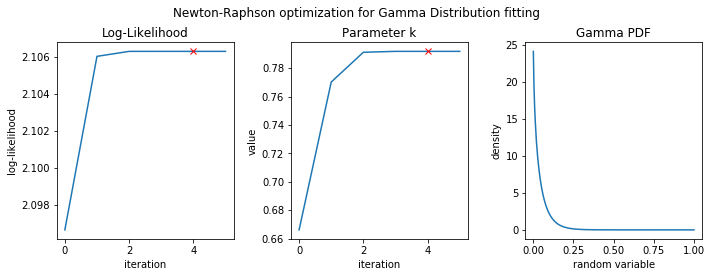

In [11]:
xx = np.arange(256) / 255
x_offset = 1/255
p_offset = 1E-6

# Gamma distribution optimization with the Newton–Raphson update
n_iter = 5
k = []
LL = []
p_gamma_LL = []

# Initialization
s = np.log(np.sum(p_bkg * (xx + x_offset))) - np.sum(p_bkg * np.log(xx + x_offset))
# k.append((3 - s + np.sqrt((s - 3) ** 2 + 24*s)) / (12*s))
k.append(0.5 / s)
theta = np.sum(p_bkg * (xx + x_offset)) / k[-1]

p_gamma_LL.append((xx + x_offset) ** (k[-1] - 1) * np.exp(- (xx + x_offset) / theta) / \
    (gamma(k[-1]) * theta ** k[-1]))
LL.append(np.sum(p_bkg * np.log(p_gamma_LL[-1] + p_offset)))

for iter in range(n_iter):
    k.append(k[-1] - (np.log(k[-1]) - digamma(k[-1]) - s) / (1/k[-1] - polygamma(1, k[-1])))
    theta = np.sum(p_bkg * (xx + x_offset)) / k[-1]
    
    p_gamma_LL.append((xx + x_offset) ** (k[-1] - 1) * np.exp(- (xx + x_offset) / theta) / \
        (gamma(k[-1]) * theta ** k[-1]))
    LL.append(np.sum(p_bkg * np.log(p_gamma_LL[-1] + p_offset)))
    
print("After %d iterations:" % n_iter)
best_iter = np.argmax(LL)
print("best_LL =", LL[best_iter])
print("k =", k[best_iter])
print("theta =", np.sum(p_bkg * (xx + x_offset)) / k[best_iter])
plt.figure(figsize=(10,4))
plt.suptitle("Newton-Raphson optimization for Gamma Distribution fitting")
plt.subplot(131)
plt.title("Log-Likelihood")
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.plot(LL)
plt.plot(best_iter, LL[best_iter], 'rx')
plt.subplot(132)
plt.title("Parameter k")
plt.xlabel("iteration")
plt.ylabel("value")
plt.plot(k)
plt.plot(best_iter, k[best_iter], 'rx')
plt.subplot(133)
plt.title("Gamma PDF")
plt.xlabel("random variable")
plt.ylabel("density")
plt.plot(xx, p_gamma_LL[best_iter])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

After 100 repetitions of GA 100 iterations with lr = 0.100000:
best_LL = 2.160628161011554
a = 0.6364582696182184
b = 11.144025875375084


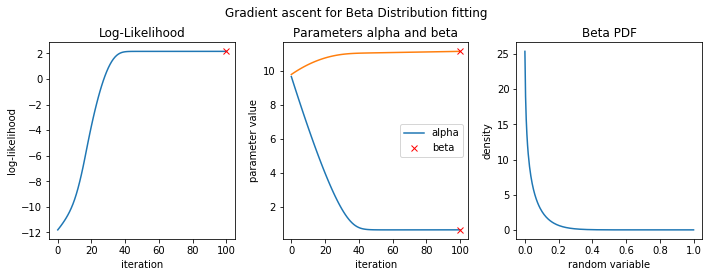

In [12]:
# Beta distribution gradient ascent on log-likelihood
lr = 0.1
n_rep = 100
n_iter = 100
best_a = []
best_b = []
best_LL = [-np.inf]

for rep in range(n_rep):
    a = [np.random.rand() * 10]
    b = [np.random.rand() * 10]
    LL = []
    p_beta_LL = (xx + x_offset) ** (a[-1] - 1) * (1 - xx + x_offset) ** (b[-1] - 1) * \
        gamma(a[-1] + b[-1]) / gamma(a[-1]) / gamma(b[-1])
    LL.append(np.sum(p_bkg * np.log(p_beta_LL + p_offset)))
    
    for iter in range(n_iter):
        grad_a = np.sum(p_bkg * np.log(xx + x_offset)) + digamma(a[-1] + b[-1]) - digamma(a[-1])
        grad_b = np.sum(p_bkg * np.log(1 - xx + x_offset)) + digamma(a[-1] + b[-1]) - digamma(b[-1])

        a.append(a[-1] + lr * grad_a)
        b.append(b[-1] + lr * grad_b)
        
        p_beta_LL = (xx + x_offset) ** (a[-1] - 1) * (1 - xx + x_offset) ** (b[-1] - 1) * \
            gamma(a[-1] + b[-1]) / gamma(a[-1]) / gamma(b[-1])
        LL.append(np.sum(p_bkg * np.log(p_beta_LL + p_offset)))
        
    if np.max(LL) > np.max(best_LL):
        best_a = a.copy()
        best_b = b.copy()
        best_LL = LL.copy()
        best_p_beta_LL = p_beta_LL.copy()
    
print("After %d repetitions of GA %d iterations with lr = %f:" % (n_rep, n_iter, lr))
best_iter = np.argmax(best_LL)
print("best_LL =", best_LL[best_iter])
print("a =", best_a[best_iter])
print("b =", best_b[best_iter])
plt.figure(figsize=(10,4))
plt.suptitle("Gradient ascent for Beta Distribution fitting")
plt.subplot(131)
plt.title("Log-Likelihood")
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.plot(best_LL)
plt.plot(best_iter, best_LL[best_iter], 'rx')
plt.subplot(132)
plt.title("Parameters alpha and beta")
plt.xlabel("iteration")
plt.ylabel("parameter value")
plt.plot(best_a)
plt.plot(best_iter, best_a[best_iter], 'rx')
plt.plot(best_b)
plt.plot(best_iter, best_b[best_iter], 'rx')
plt.legend(["alpha", "beta"])
plt.subplot(133)
plt.title("Beta PDF")
plt.xlabel("random variable")
plt.ylabel("density")
plt.plot(xx, best_p_beta_LL)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

E(X) = 0.041733140976778674
STD(X) = 0.0607942008337622
LL_exp = 2.1769463460959373
LL_gamma = 2.1063011946155648
LL_beta = 2.157996448842985

KL_exp = 0.17124148347554913
KL_gamma = 0.11748763272829921
KL_beta = 0.12194089756188309


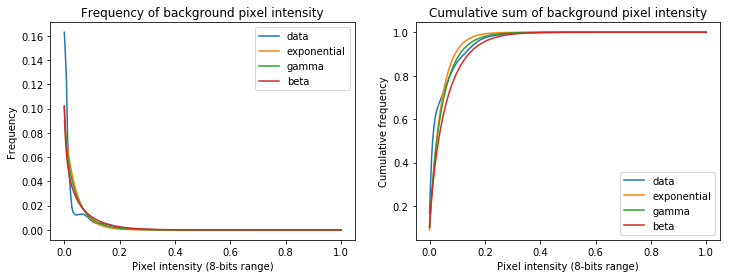

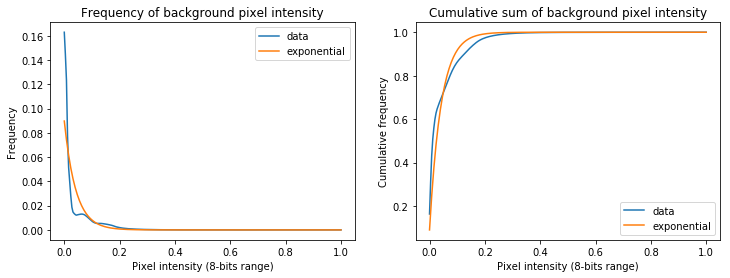

In [13]:
print("E(X) =", np.sum(p_bkg * xx))
print("STD(X) =", np.sqrt(np.sum(p_bkg * (xx - np.sum(p_bkg * xx)) ** 2)))

# Exponential distribution
lambda_hat = 1 / np.sum(p_bkg * xx)
p_exp = lambda_hat * np.exp(- lambda_hat * xx)
p_exp += p_offset
print("LL_exp =", np.sum(p_bkg * np.log(p_exp)))
p_exp /= p_exp.sum()

# Gamma distribution (with slight offset as 0 cannot be included)
k_hat = 0.7917790387034535
theta_hat = 0.05766092226814912
p_gamma = (xx + x_offset) ** (k_hat - 1) * np.exp(- (xx + x_offset) / theta_hat) / \
    (gamma(k_hat) * theta_hat ** k_hat)
p_gamma += p_offset
print("LL_gamma =", np.sum(p_bkg * np.log(p_gamma)))
p_gamma /= p_gamma.sum()

# Beta distribution (see optimization above)
a_hat = 0.6323152855911088
b_hat = 10.994133477060398
p_beta = (xx + x_offset) ** (a_hat - 1) * (1 - xx + x_offset) ** (b_hat - 1) * \
    gamma(a_hat + b_hat) / gamma(a_hat) / gamma(b_hat)
p_beta += p_offset
print("LL_beta =", np.sum(p_bkg * np.log(p_beta)))
p_beta /= p_beta.sum()

print("\nKL_exp =", entropy(p_bkg, p_exp))
print("KL_gamma =", entropy(p_bkg, p_gamma))
print("KL_beta =", entropy(p_bkg, p_beta))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xx, p_bkg)
plt.plot(xx, p_exp)
plt.plot(xx, p_gamma)
plt.plot(xx, p_beta)
plt.title("Frequency of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Frequency")
plt.legend(["data", "exponential", "gamma", "beta"])
plt.subplot(122)
plt.plot(xx, np.cumsum(p_bkg))
plt.plot(xx, np.cumsum(p_exp))
plt.plot(xx, np.cumsum(p_gamma))
plt.plot(xx, np.cumsum(p_beta))
plt.title("Cumulative sum of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Cumulative frequency")
plt.legend(["data", "exponential", "gamma", "beta"])
plt.show()

# Only true and exponential
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xx, p_bkg)
plt.plot(xx, p_exp)
plt.title("Frequency of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Frequency")
plt.legend(["data", "exponential"])
plt.subplot(122)
plt.plot(xx, np.cumsum(p_bkg))
plt.plot(xx, np.cumsum(p_exp))
plt.title("Cumulative sum of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Cumulative frequency")
plt.legend(["data", "exponential"])
plt.show()

(0, 0.5)

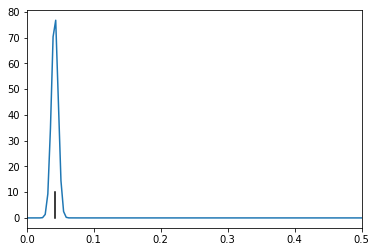

In [14]:
# Add variability to background intensity
plt.plot(np.arange(256)/255, 
         norm.pdf(np.arange(256)/255, 
                  loc=np.sum(p_bkg * np.arange(256) / 255), scale=0.005))
plt.plot([np.sum(p_bkg * np.arange(256) / 255), np.sum(p_bkg * np.arange(256) / 255)],
         [0, 10], 'k')
plt.xlim(0,0.5)

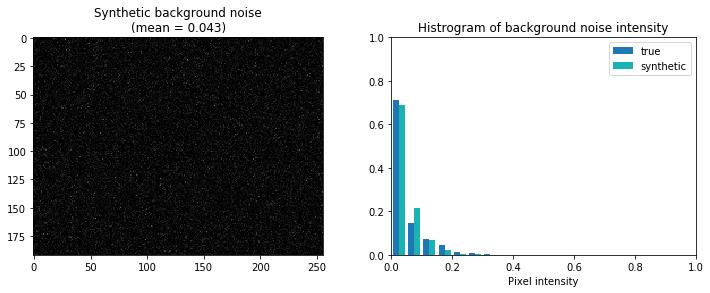

In [15]:
bkg = np.zeros(shape, dtype=np.float32)

noise_mean = np.random.normal(loc=np.sum(p_bkg * np.arange(256) / 255), scale=0.005)
noise = np.random.exponential(scale=noise_mean, size=shape)

noise_hist = plt.hist(noise.ravel(), align="mid", bins=new_bins, weights=np.ones(noise.size) / noise.size)[0]
plt.close()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(bkg + noise, vmin=0, vmax=1, cmap='gray')
plt.title("Synthetic background noise\n(mean = %.3f)" % noise_mean)
plt.subplot(122)
plt.bar(new_bins[:-1] + offset_left, new_pixel_bkg / new_pixel_bkg.sum(), width=width)
plt.bar(new_bins[:-1] + offset_right, noise_hist, width=width, color=[0.1, 0.7, 0.7])
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histrogram of background noise intensity")
plt.xlabel("Pixel intensity")
plt.legend(["true", "synthetic"])
plt.show()

# All together 

Mix background, warped neurons and background noise together. Using simple addition might causes the neurons to be too bright, so we use max().

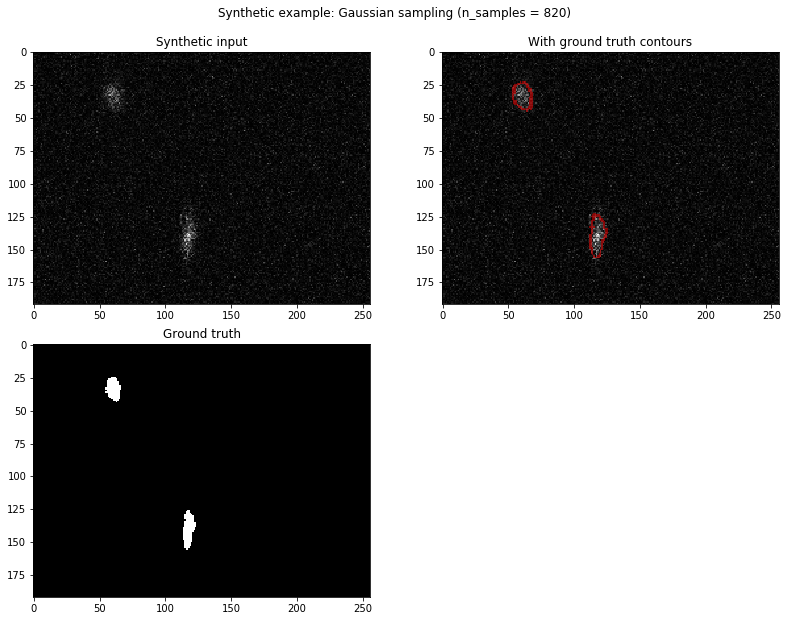

In [16]:
img_display = np.stack([bkg, wrp_neurons_weight, noise], axis=0).max(axis=0)

plt.figure(figsize=(11.5,9))
plt.suptitle("Synthetic example: Gaussian sampling (n_samples = %d)" % n_samples)
plt.subplot(221)
plt.title("Synthetic input")
plt.imshow(img_display, vmin=0, vmax=1, cmap='gray')
plt.subplot(222)
plt.title("With ground truth contours")
plt.imshow(overlay_mask(img_display, 
                        wrp_contours.sum(0), opacity=0.5, mask_color=[1,0,0]))
plt.subplot(223)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

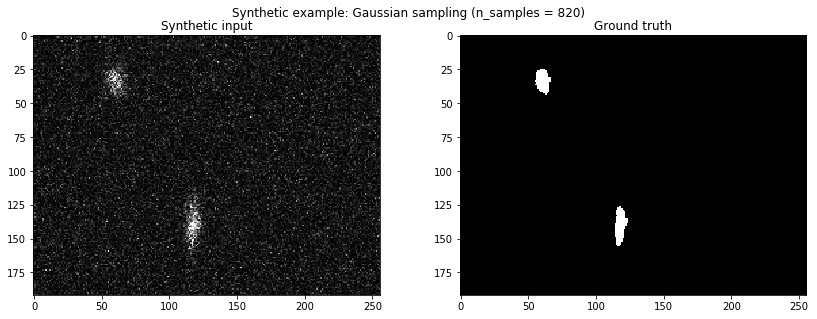

In [17]:
# Test random saturations
img_display = np.stack([bkg, wrp_neurons_weight, noise], axis=0).max(axis=0).clip(0,0.5)

plt.figure(figsize=(12,4.5))
plt.suptitle("Synthetic example: Gaussian sampling (n_samples = %d)" % n_samples)
plt.subplot(121)
plt.title("Synthetic input")
plt.imshow(img_display, cmap='gray')
plt.subplot(122)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()